### 1. Carregando Bibliotecas

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from keras.models import Sequential,load_model
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import  to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, BatchNormalization


In [24]:
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is None:
            warnings.warn('Can save best model only with val_accuracy available, skipping.')
        else:
            try:
                # Load the saved model
                saved_model = load_model(self.filepath)

                # Evaluate the saved model on the validation set
                saved_val_loss, saved_val_acc = saved_model.evaluate(x_val, y_val, verbose=0)

                # If the new model is better, save it
                if val_accuracy > saved_val_acc:
                    self.model.save(self.filepath)
                    print('Epoch', epoch+1, ': found a better model with validation accuracy', val_accuracy)
            except Exception:
                # If there is no saved model yet, save the new model
                self.model.save(self.filepath)
                print('Epoch', epoch+1, ': found the first model with validation accuracy', val_accuracy)


In [2]:
# Configurando o matplotlib
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]

### 2. Carregando o dataset pré-embaralhado de treinamento bem como os dados de teste

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


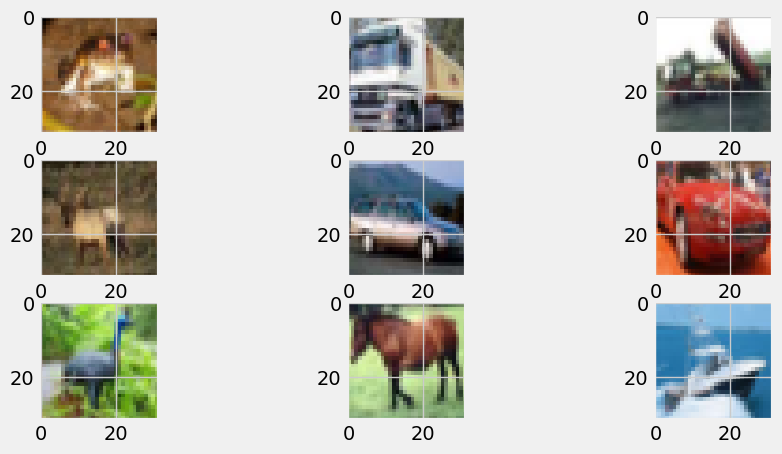

In [5]:
print(f'Train: X={x_train.shape}, y={y_train.shape}')
print(f'Test: X={x_test.shape}, y={y_test.shape}')
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(x_train[i])
# show the figure
plt.show()

### 3. Redimensionando as imagens e dividindo cada pixel em cada imagem por 255

In [6]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 4.  Dividindo o dataset em treinamento, teste e validação

In [7]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [9]:
num_classes

10

In [10]:
x_train.shape

(50000, 32, 32, 3)

In [11]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

Impressão do número de imagens nos datasets de treinamento, teste e validação

In [14]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


### 5. Arquitetura

In [18]:
# Definindo a arquitetura do modelo
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

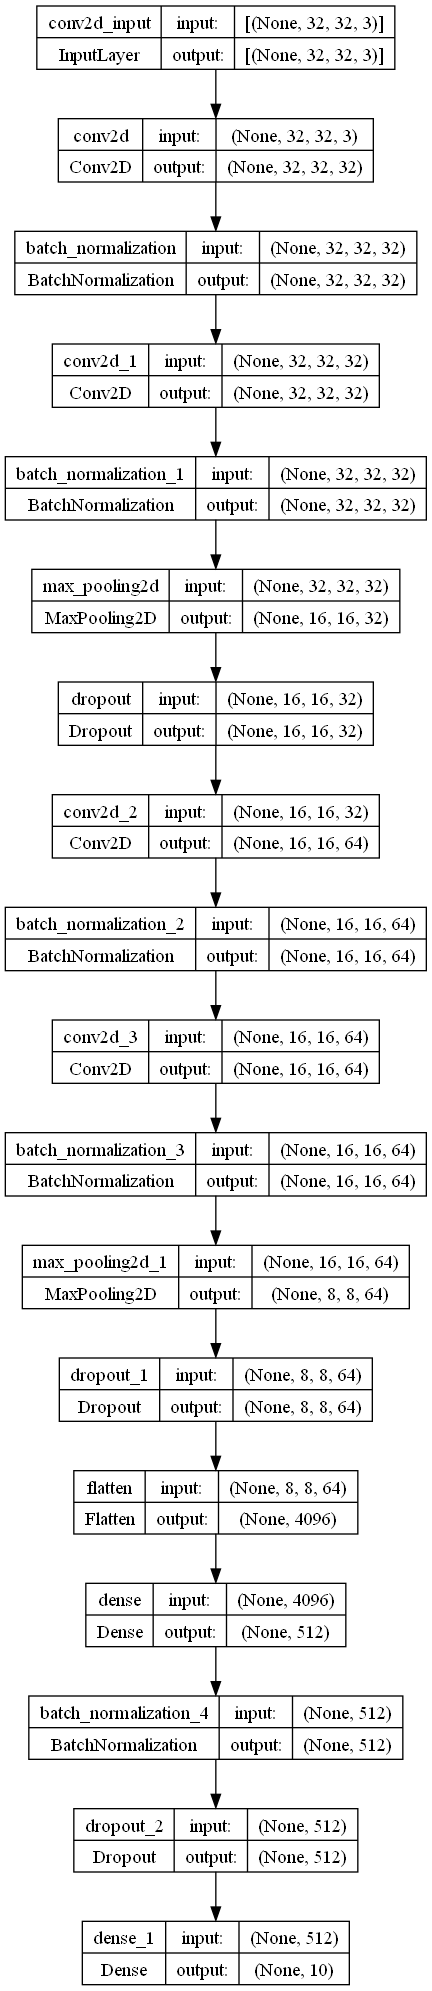

In [19]:
plot_model(model, to_file='cnn-CIFAR10.png', show_shapes=True, show_layer_names=True)

### 6. Treinando o modelo

In [27]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
model_checkpoint = CustomModelCheckpoint('best_model.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])                  

hist = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_valid, y_valid), callbacks=[model_checkpoint, early_stopping], verbose=1, shuffle=True)


Epoch 1/100
176/176 [==============================] - 79s 443ms/step - loss: 0.3049 - accuracy: 0.8923 - val_loss: 0.5465 - val_accuracy: 0.8256
Epoch 2/100
176/176 [==============================] - 78s 443ms/step - loss: 0.2605 - accuracy: 0.9078 - val_loss: 0.5402 - val_accuracy: 0.8254
Epoch 3/100
176/176 [==============================] - 78s 445ms/step - loss: 0.2309 - accuracy: 0.9186 - val_loss: 0.5727 - val_accuracy: 0.8212
Epoch 4/100
176/176 [==============================] - 78s 442ms/step - loss: 0.2166 - accuracy: 0.9248 - val_loss: 0.5394 - val_accuracy: 0.8298
Epoch 5/100
176/176 [==============================] - 76s 433ms/step - loss: 0.2012 - accuracy: 0.9284 - val_loss: 0.5615 - val_accuracy: 0.8232
Epoch 6/100
176/176 [==============================] - 76s 431ms/step - loss: 0.1793 - accuracy: 0.9362 - val_loss: 0.5670 - val_accuracy: 0.8314
Epoch 7/100
176/176 [==============================] - 76s 434ms/step - loss: 0.1767 - accuracy: 0.9368 - val_loss: 0.6242 -

### 7. Análise dos resultados

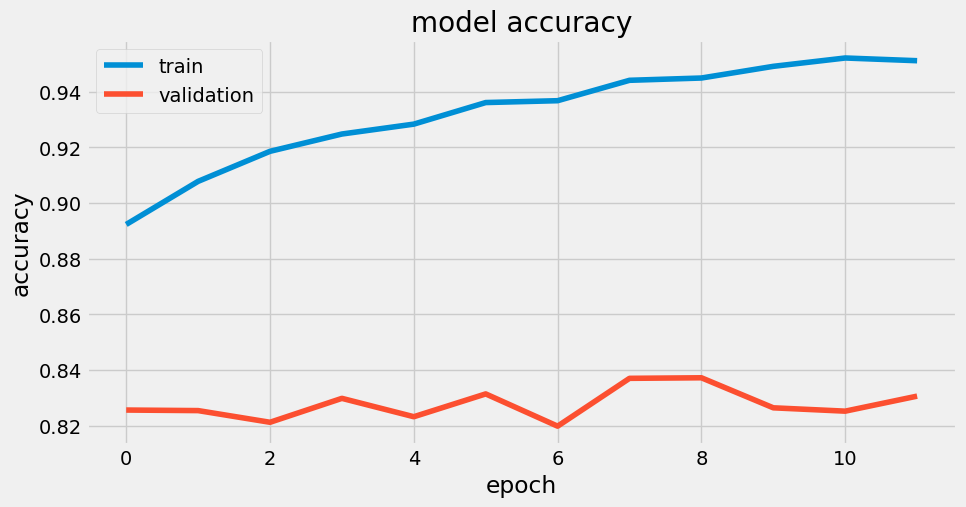

In [28]:
plt.figure(1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [32]:
# Load the saved model
best_model = load_model('best_model.h5')

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

313/313 [==============================] - 4s 12ms/step - loss: 0.6355 - accuracy: 0.8259
Test accuracy: 0.8259000182151794


O modelo manteve a acuracia de validação em torno dos 82% +- depois da 10ª epoca, e depois foi acontecendo um overfiting nos dados de treino, vamos ver em qual epoca houve o pico que ficou proximo da acurácia de treino. O que poderia ter evitado isso também é ter acompanhada a val_loss no EarlyStopping.

### 8. Visualizar algumas predições

As visualizações podem nos dar algumas dicas sobre por que a rede classifica erroneamente alguns objetos.
Obtendo previsões no conjunto de testes:

In [33]:
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [34]:
y_hat = best_model.predict(x_test)

313/313 [==============================] - 4s 11ms/step


In [35]:
y_hat

array([[2.1239241e-08, 1.1750920e-08, 7.2527551e-10, ..., 1.8509680e-09,
        2.1576419e-05, 1.7019076e-08],
       [3.0739199e-07, 3.9493945e-01, 8.1925408e-16, ..., 2.8944371e-19,
        6.0506028e-01, 7.4911508e-11],
       [2.8074358e-04, 3.0687824e-02, 6.3461754e-05, ..., 3.7162889e-07,
        9.6893680e-01, 2.8712302e-05],
       ...,
       [3.2378475e-09, 4.4988588e-12, 1.7671047e-03, ..., 2.4458850e-04,
        3.5169168e-09, 1.0806802e-08],
       [1.8461552e-04, 9.9975926e-01, 2.6396763e-05, ..., 9.3835233e-09,
        1.1957928e-08, 2.5650385e-07],
       [4.6908332e-13, 4.8730348e-10, 4.0898476e-10, ..., 9.9999690e-01,
        7.2072540e-13, 6.3343532e-12]], dtype=float32)

In [36]:
y_hat[100,:]

array([1.0712488e-06, 1.4967557e-09, 3.5861300e-04, 2.7867974e-04,
       7.2091305e-01, 8.8682899e-04, 8.1221742e-08, 2.7755901e-01,
       8.9276006e-07, 1.7298372e-06], dtype=float32)

In [37]:
np.argmax(y_hat[100,:])

4

In [38]:
y_test[100,:]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [39]:
np.argmax(y_test[100,:])

4

Plot de amostra aleatória de imagens de teste, rótulos preditos e a "ground truth" advinda do dataset CIFAR-10

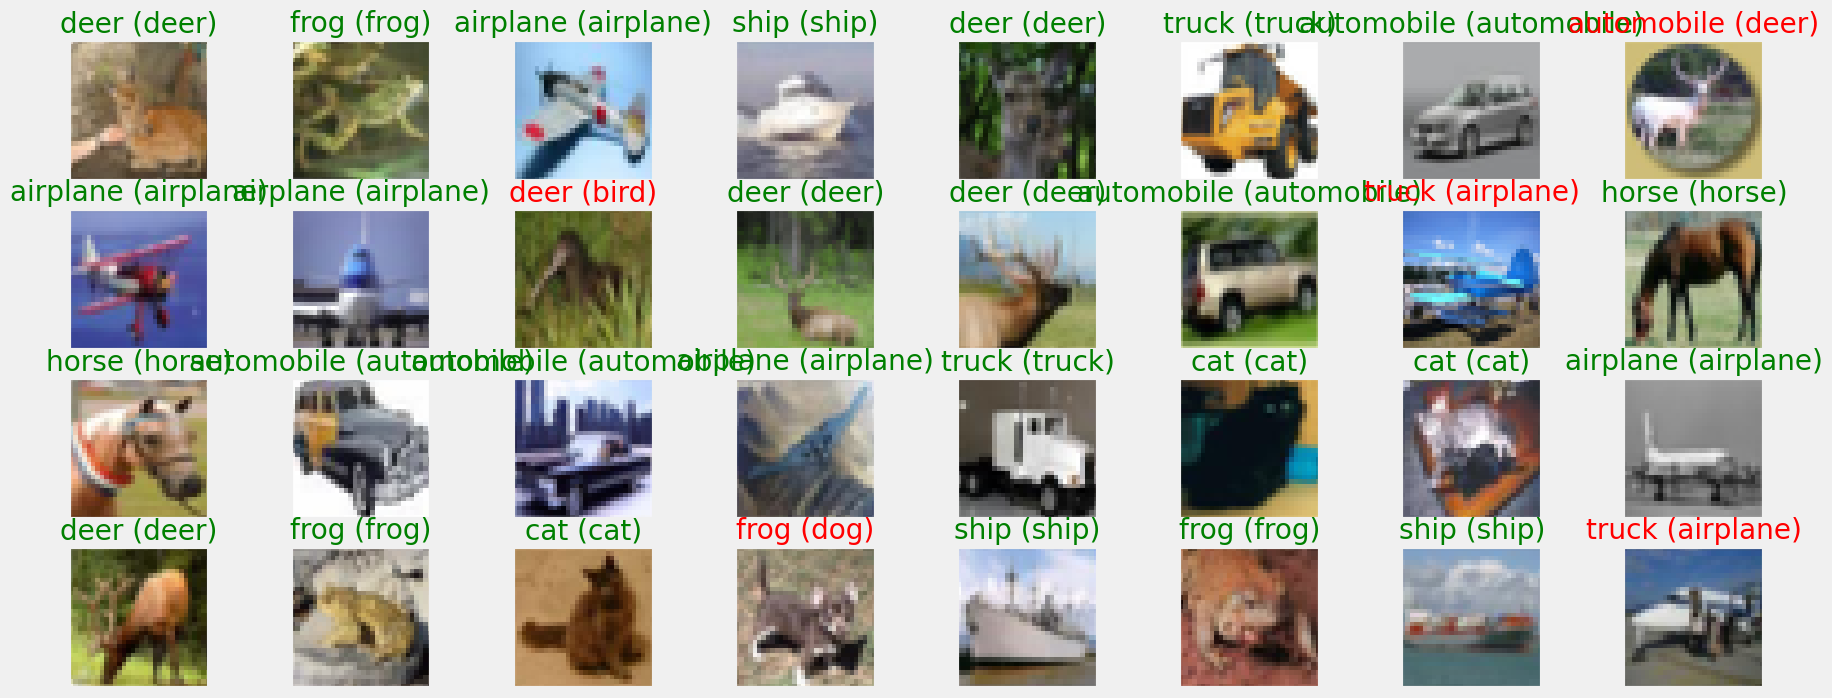

In [40]:
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title(
        f"{cifar10_labels[pred_idx]} ({cifar10_labels[true_idx]})",
        color=("green" if pred_idx == true_idx else "red"),
    )
    # amostras corretamente classificadas em verde, incorretamente classificadas em vermelho
